### Build A Basic Chatbot With Langgraph(GRAPH API)

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages ##Reducer
 

In [2]:
class State(TypedDict): ##Rrturn type is dict
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]



In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama-3.1-8b-instant")

In [5]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10ce3d7f0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10ce3e3c0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
llm=init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10cf45590>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10cf45f90>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [8]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

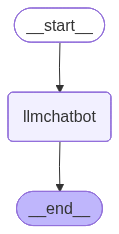

In [9]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
response=graph.invoke({"messages":"Hi"})
response

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='c8f9eaa3-fadd-4d2b-9aa2-4fd0841616fd'),
  AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.006552675, 'prompt_time': 0.001559377, 'queue_time': 0.054714673, 'total_time': 0.008112052}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_e32974efee', 'finish_reason': 'stop', 'logprobs': None}, id='run--5c014112-d45a-4066-a027-acacc5858042-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})]}

In [11]:
response["messages"][-1].content

'How can I assist you today?'

In [12]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm doing well, thank you for asking. I'm a large language model, so I don't have emotions or feelings like humans do, but I'm here and ready to help you with any questions or topics you'd like to discuss. How can I assist you today?


### Chatbot With Tool

In [13]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)  
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://langchain-ai.github.io/langgraph/',
   'title': 'LangGraph - GitHub Pages',
   'content': 'Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents. LangGraph is very low-level, and focused entirely on agent **orchestration**. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools. LangGraph is focused on the underlying capabilities important for agent orchestration: durable execution, streaming, human-in-the-loop, and more. LangGraph provides low-level supporting infrastructure for *any* long-running, stateful workflow or agent. While LangGraph can be used standalone, it also integrates seamlessly with any LangCh

In [14]:
## Custom function
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [15]:
tools=[tool,multiply]

In [16]:
llm_with_tool=llm.bind_tools(tools)

In [17]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10cf45590>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x10cf45f90>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domai

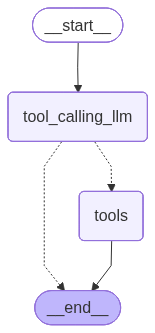

In [18]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))



In [19]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [20]:
response['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://fortune.com/2025/11/01/geoffrey-hinton-godfather-of-ai-investment-tech-company-profits-human-labor-replacement/", "title": "\'Godfather of AI\' says tech giants can\'t profit from their astronomical investments unless human labor is replaced - Fortune", "score": 0.6914979, "published_date": "Sat, 01 Nov 2025 18:43:00 GMT", "content": "Just four so-called AI hyperscalers—Microsoft, Meta, Alphabet and Amazon—are expected to boost capital expenditures to $420 billion next fiscal year from $360 billion this year, according to Bloomberg.\\n\\nMeanwhile, OpenAI alone has announced a total of $1 trillion in infrastructure deals in recent weeks with AI-ecosystem companies like Nvidia, Broadcom and Oracle. [...] In fact, evidence is mounting that AI is shrinking opportunities, especially at the entry level, and an analysis of job openings since OpenAI launched ChatGPT shows they 

In [21]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (b42k27sry)
 Call ID: b42k27sry
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://fortune.com/2025/11/01/geoffrey-hinton-godfather-of-ai-investment-tech-company-profits-human-labor-replacement/", "title": "'Godfather of AI' says tech giants can't profit from their astronomical investments unless human labor is replaced - Fortune", "score": 0.6914979, "published_date": "Sat, 01 Nov 2025 18:43:00 GMT", "content": "Just four so-called AI hyperscalers—Microsoft, Meta, Alphabet and Amazon—are expected to boost capita

In [22]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (cyhtr28tv)
 Call ID: cyhtr28tv
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [23]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (mxrpmd8b0)
 Call ID: mxrpmd8b0
  Args:
    query: recent ai news
    topic: news
  multiply (r3bjqjz5w)
 Call ID: r3bjqjz5w
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.businessinsider.com/amazon-cuts-14-000-corporate-jobs-amid-ai-restructuring-2025-10", "title": "Amazon Cuts 14,000 Corporate Jobs Amid AI Restructuring - businessinsider.com", "score": 0.5809471, "published_date": "Wed, 29 Oct 2025 20:09:21 GMT", "content": "Subscribe   Newsletters Video   News # Amazon cuts 14,000 corporate jobs amid AI restructuring Amazon just made its biggest

### ReAct Agent Architecture

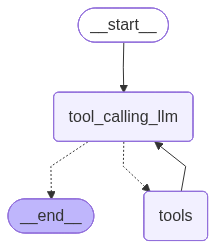

In [24]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (3q2myra42)
 Call ID: 3q2myra42
  Args:
    query: recent AI news
    topic: news
  multiply (kn7brpfkq)
 Call ID: kn7brpfkq
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.businessinsider.com/amazon-cuts-14-000-corporate-jobs-amid-ai-restructuring-2025-10", "title": "Amazon Cuts 14,000 Corporate Jobs Amid AI Restructuring - businessinsider.com", "score": 0.57637566, "published_date": "Wed, 29 Oct 2025 20:09:21 GMT", "content": "Subscribe   Newsletters Video   News # Amazon cuts 14,000 corporate jobs amid AI restructuring Amazon just made its bigges

## Adding Memory In Agentic Graph

In [26]:
response=graph.invoke({"messages":"Hello my name is KRish"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is KRish
================================== Ai Message ==================================

Nice to meet you KRish. How can I assist you today?


In [27]:
response=graph.invoke({"messages":"What is my name"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================

I don't have any information about your name.


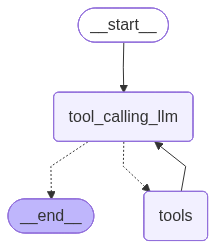

In [28]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory) 

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Krish"},config=config)

response



{'messages': [HumanMessage(content='Hi my name is Krish', additional_kwargs={}, response_metadata={}, id='3f396e08-f1cf-4e74-bb65-2835425de80f'),
  AIMessage(content='Nice to meet you, Krish. Is there anything I can help you with today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 1247, 'total_tokens': 1265, 'completion_time': 0.024245627, 'prompt_time': 0.073796484, 'queue_time': 0.054419855, 'total_time': 0.098042111}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_e32974efee', 'finish_reason': 'stop', 'logprobs': None}, id='run--be87bbfe-2f29-4924-a42c-eae237fef696-0', usage_metadata={'input_tokens': 1247, 'output_tokens': 18, 'total_tokens': 1265})]}

In [30]:
response['messages'][-1].content

'Nice to meet you, Krish. Is there anything I can help you with today?'

In [31]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

Your name is Krish.


In [34]:
response=graph.invoke({"messages":"Hey do you remember mmy name"},config=config)

print(response['messages'][-1].content)

Yes, your name is Krish.


### Streaming

In [35]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [36]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

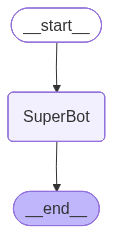

In [37]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [38]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Krish And I like cricket"},config)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='0a972bc2-a410-4ce6-8bb6-68ab5cc97860'),
  AIMessage(content='Nice to meet you, Krish. Cricket is a fantastic sport. Which team or player is your favorite in cricket? Are you a fan of Indian cricket or do you follow international teams like Australia, England, or Pakistan?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 45, 'total_tokens': 90, 'completion_time': 0.066684281, 'prompt_time': 0.002076053, 'queue_time': 0.048657057, 'total_time': 0.068760334}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'finish_reason': 'stop', 'logprobs': None}, id='run--b0f0f217-dab2-4b81-9854-232ffe24b064-0', usage_metadata={'input_tokens': 45, 'output_tokens': 45, 'total_tokens': 90})]}

### Streaming 
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [39]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, Krish. Cricket is a fantastic sport, isn't it? Which team do you support? Are you more of a fan of international cricket or domestic leagues like the IPL?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 45, 'total_tokens': 85, 'completion_time': 0.053504188, 'prompt_time': 0.002369332, 'queue_time': 0.050365238, 'total_time': 0.05587352}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'finish_reason': 'stop', 'logprobs': None}, id='run--41ca72ae-59b8-418d-8786-e9003d3e9a1f-0', usage_metadata={'input_tokens': 45, 'output_tokens': 40, 'total_tokens': 85})]}}


In [40]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='232a45b0-f6b2-4221-b971-efa8920d4f0a'), AIMessage(content="Nice to meet you, Krish. Cricket is a fantastic sport, isn't it? Which team do you support? Are you more of a fan of international cricket or domestic leagues like the IPL?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 45, 'total_tokens': 85, 'completion_time': 0.053504188, 'prompt_time': 0.002369332, 'queue_time': 0.050365238, 'total_time': 0.05587352}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'finish_reason': 'stop', 'logprobs': None}, id='run--41ca72ae-59b8-418d-8786-e9003d3e9a1f-0', usage_metadata={'input_tokens': 45, 'output_tokens': 40, 'total_tokens': 85}), HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='ba8338e8-98c1-4fce-bf68-c0e905278e3a')]}
{'

In [ ]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Krish And I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, Krish. Cricket is a fantastic sport, and it's great to hear that you enjoy it. Are you a fan of any particular team or player? Do you have a favorite format of the game, such as Test cricket, One Day Internationals (ODIs), or Twenty20 (T20)?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 45, 'total_tokens': 112, 'completion_time': 0.07653162, 'prompt_time': 0.002108413, 'queue_time': 0.054936037, 'total_time': 0.078640033}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'finish_reason': 'stop', 'logprobs': None}, id='run--cad7e316-1866-4e4e-8371-7e2c0b4e990a-0', usage_metadata={'input_tokens': 45, 'output_tokens': 67, 'total_tokens': 112})]}}


In [ ]:
for chunk in graph_builder.stream({'messages':"I also like football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Krish And I like cricket', additional_kwargs={}, response_metadata={}, id='ea8c5e6d-a890-4ef5-bb2c-faa4a59dba42'), AIMessage(content="Nice to meet you, Krish. Cricket is a fantastic sport, and it's great to hear that you enjoy it. Are you a fan of any particular team or player? Do you have a favorite format of the game, such as Test cricket, One Day Internationals (ODIs), or Twenty20 (T20)?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 45, 'total_tokens': 112, 'completion_time': 0.07653162, 'prompt_time': 0.002108413, 'queue_time': 0.054936037, 'total_time': 0.078640033}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'finish_reason': 'stop', 'logprobs': None}, id='run--cad7e316-1866-4e4e-8371-7e2c0b4e990a-0', usage_metadata={'input_tokens': 45, 'output_tokens': 67, 'total_tokens': 112}), HumanMessage(content='I also like football', additional_kwargs={}

In [ ]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is Krish and I like to play cricket"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is Krish and I like to play cricket']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'baf0a8a1-c585-4b42-8efb-b6a57f8e0d9e', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is Krish and I like to play cricket', additional_kwargs={}, response_metadata={}, id='c5e436a8-47a7-476a-9468-63a1235c2174')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '6ce4ba14-a29c-448c-8b65-6e347a5c2623', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:6f4e0e71-9b90-fe5c-7f97-3561fb9e907e'}, 'parent_ids': ['baf0a8a1-c585-4b42-8efb-b6a57f8e0d9e']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is Krish and I like to pla